# **Skenario 6 - CNN VGG16 - SVM**

Skenario 6 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur VGG16 sebagai ekstraksi fitur dan SVM sebagai algoritma untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict


# TensorFlow and Keras imports
import tensorflow as tf
from keras import layers, models, optimizers
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.layers import Input, Dense,GlobalAveragePooling2D,Flatten,MaxPool2D
from keras.models import Model

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data(preprocess_images=True):
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Load data from the NPZ file
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Prepare lists for input (X) and output (Y) data
    X = []
    Y = []

    # Create a label mapping for each class
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterate through the loaded data
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                if preprocess_images:
                    # Expand dimensions and repeat for RGB representation
                    original_slice = np.expand_dims(original_slice, axis=-1)
                    original_slice = np.repeat(original_slice, 3, axis=-1)

                    # Min-Max Scaling to bring pixel values to the range [0, 1]
                    min_val = np.min(original_slice)
                    max_val = np.max(original_slice)
                    original_slice = (original_slice - min_val) / (max_val - min_val)

                X.append(original_slice)
                Y.append(label_mapping[label])

    # Convert lists to NumPy arrays
    X = np.array(X) 
    Y = np.array(Y)

    return X, Y

In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data()

In [4]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (7200, 224, 224, 3)
Y shape: (7200,)


In [5]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [7]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760,)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440,)


In [8]:
Y_train[0]

1

In [9]:
print("Jumlah sampel dalam X_train:", len(X_train))
print("Jumlah sampel dalam Y_train:", len(Y_train))
print("Jumlah sampel dalam X_test:", len(X_test))
print("Jumlah sampel dalam Y_test:", len(Y_test))

Jumlah sampel dalam X_train: 5760
Jumlah sampel dalam Y_train: 5760
Jumlah sampel dalam X_test: 1440
Jumlah sampel dalam Y_test: 1440


## 3. Buat dan Konfigurasi Model Ekstraksi Fitur
Arsitektur yang digunakan sebagai ekstraksi fitur adalah VGG16 yang merupakan dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [10]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

Load model yang udah dilatih sebelumnya

In [11]:
from keras.models import load_model

model_path = r"D:\Users\RESA\Coding\Evaluasi\VGG16.h5"
loaded_model = load_model(model_path, custom_objects={'specificity': specificity, 'sensitivity': sensitivity})

In [12]:
extractCNN = Model(loaded_model.inputs, loaded_model.layers[-2].output)
feat_trainCNN = extractCNN.predict(X_train)
feat_testCNN = extractCNN.predict(X_test)
print("Shape of train features:", feat_trainCNN.shape)
print("Shape of test features:", feat_testCNN.shape)

45/45 [==============================] - 90s 2s/step
Shape of train features: (5760, 4096)
Shape of test features: (1440, 4096)


Reshape fitur

In [13]:
flat_feat_trainCNN = feat_trainCNN.reshape((feat_trainCNN.shape[0], -1))
flat_feat_testCNN = feat_testCNN.reshape((feat_testCNN.shape[0], -1))

In [14]:
print("Dimensi train sebelum reshaping:", feat_trainCNN.shape)
print("Dimensi train setelah reshaping:", flat_feat_trainCNN.shape)
print("Dimensi test sebelum reshaping:", feat_testCNN.shape)
print("Dimensi test setelah reshaping:", flat_feat_testCNN.shape)

Dimensi train sebelum reshaping: (5760, 4096)
Dimensi train setelah reshaping: (5760, 4096)
Dimensi test sebelum reshaping: (1440, 4096)
Dimensi test setelah reshaping: (1440, 4096)


## 5. Training Model - Cross Validation
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

### 5.1 Kernel RBF

Training

In [15]:
svm_rbf = SVC(kernel='rbf', probability=True, decision_function_shape='ovr')
scores_rbf = cross_val_score(svm_rbf, flat_feat_trainCNN, Y_train, cv=5, scoring='accuracy')
svm_rbf.fit(flat_feat_trainCNN, Y_train) 
print("Skor Akurasi untuk Setiap Fold:")
print(scores_rbf)
print("\nRata-rata Skor Akurasi:")
print(scores_rbf.mean())

Skor Akurasi untuk Setiap Fold:
[0.98177083 0.98350694 0.984375   0.9765625  0.97916667]

Rata-rata Skor Akurasi:
0.9810763888888889


In [16]:
best_rbf_fold_index = np.argmax(scores_rbf)

# Buat model untuk fold terbaik dan fit model
best_svm_rbf = SVC(kernel='rbf', probability=True, decision_function_shape='ovr')
best_svm_rbf.fit(flat_feat_trainCNN, Y_train)

SVC(probability=True)

In [17]:
if best_svm_rbf.n_support_.any() > 0:
    print("Model telah dilatih.")
else:
    print("Model belum dilatih atau terdapat masalah saat pelatihan.")

Model telah dilatih.


Simpan model

In [18]:
model_svm_rbf = r"D:/Users/RESA/Coding/Evaluasi/VGG16_svm_model_rbf.pkl"
with open(model_svm_rbf, 'wb') as model_file:
    pickle.dump(best_svm_rbf, model_file)

Testing

In [19]:
svm_rbf.fit(flat_feat_trainCNN, Y_train)
predictions_test = svm_rbf.predict(flat_feat_testCNN)
print("Label Sebenarnya:")
print(Y_test)
print("\nLabel Prediksi:")
print(predictions_test)
accuracy_test = np.mean(predictions_test == Y_test)
print("\nAkurasi pada Data Uji:", accuracy_test)

Label Sebenarnya:
[1 1 2 ... 3 1 1]

Label Prediksi:
[1 1 2 ... 1 1 1]

Akurasi pada Data Uji: 0.8395833333333333


Evaluasi

In [20]:
#  Classification report data test
predictions_test = svm_rbf.predict(flat_feat_testCNN)

# Membuat classification report
classification_rep = classification_report(Y_test, predictions_test)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       380
           1       0.70      0.84      0.76       338
           2       0.88      0.85      0.87       363
           3       0.93      0.84      0.88       359

    accuracy                           0.84      1440
   macro avg       0.85      0.84      0.84      1440
weighted avg       0.85      0.84      0.84      1440



In [21]:
#  Classification report data train

predictions_train = svm_rbf.predict(flat_feat_trainCNN)
classification_rep_train = classification_report(Y_train, predictions_train)
print("Classification Report untuk Data Pelatihan:")
print(classification_rep_train)

Classification Report untuk Data Pelatihan:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1420
           1       0.95      0.98      0.97      1462
           2       0.99      0.99      0.99      1437
           3       1.00      0.97      0.98      1441

    accuracy                           0.98      5760
   macro avg       0.98      0.98      0.98      5760
weighted avg       0.98      0.98      0.98      5760



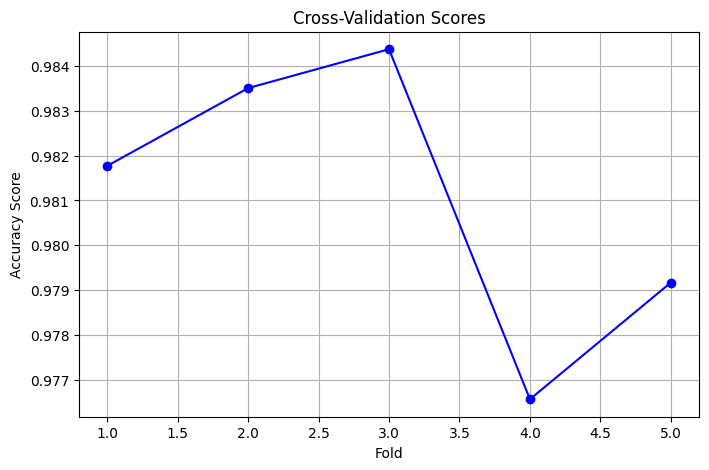

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), scores_rbf, marker='o', linestyle='-', color='blue')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Scores')
plt.grid(True)
plt.show()

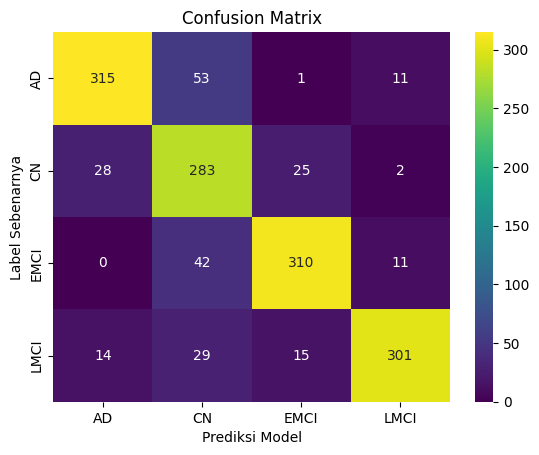

In [23]:
predictions_test = svm_rbf.predict(flat_feat_testCNN)

conf_matrix_rbf = confusion_matrix(Y_test, predictions_test)

# Membuat heatmap untuk confusion matrix
sns.heatmap(conf_matrix_rbf, annot=True, fmt='g', cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.show()

In [24]:
sensitivity = conf_matrix_rbf[1, 1] / (conf_matrix_rbf[1, 0] + conf_matrix_rbf[1, 1])
specificity = conf_matrix_rbf[0, 0] / (conf_matrix_rbf[0, 0] + conf_matrix_rbf[0, 1])

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.909967845659164
Specificity: 0.8559782608695652


In [25]:
# Data train

predictions_train = svm_rbf.predict(flat_feat_trainCNN)
conf_matrix_train = confusion_matrix(Y_train, predictions_train)
sensitivity_train = conf_matrix_train[1, 1] / (conf_matrix_train[1, 0] + conf_matrix_train[1, 1])
specificity_train = conf_matrix_train[0, 0] / (conf_matrix_train[0, 0] + conf_matrix_train[0, 1])

# Menampilkan hasil
print("Sensitivity untuk Data Pelatihan:", sensitivity_train)
print("Specificity untuk Data Pelatihan:", specificity_train)

Sensitivity untuk Data Pelatihan: 0.9828178694158075
Specificity untuk Data Pelatihan: 0.9894217207334274


### 5.2 Kernel Polinomial

Training

In [26]:
svm_poly = SVC(kernel='poly', probability=True, decision_function_shape='ovr')
scores_poly = cross_val_score(svm_poly, flat_feat_trainCNN, Y_train, cv=5, scoring='accuracy')
svm_poly.fit(flat_feat_trainCNN, Y_train) 
print("Skor Akurasi untuk Setiap Fold:")
print(scores_poly)
print("\nRata-rata Skor Akurasi:")
print(scores_poly.mean())

Skor Akurasi untuk Setiap Fold:
[0.98090278 0.98090278 0.97829861 0.97569444 0.97309028]

Rata-rata Skor Akurasi:
0.9777777777777779


In [27]:
best_poly_fold_index = np.argmax(scores_poly)

# Buat model untuk fold terbaik dan fit model
best_svm_poly = SVC(kernel='poly', probability=True, decision_function_shape='ovr')
best_svm_poly.fit(flat_feat_trainCNN, Y_train)

SVC(kernel='poly', probability=True)

In [28]:
if best_svm_poly.n_support_.any() > 0:
    print("Model telah dilatih.")
else:
    print("Model belum dilatih atau terdapat masalah saat pelatihan.")

Model telah dilatih.


Simpan model

In [29]:
model_svm_poly = r"D:/Users/RESA/Coding/Evaluasi/VGG16_svm_model_poly.pkl"
with open(model_svm_poly, 'wb') as model_file:
    pickle.dump(best_svm_poly, model_file)

Testing

In [30]:
svm_poly.fit(flat_feat_trainCNN, Y_train)
predictions_test = svm_poly.predict(flat_feat_testCNN)
print("Label Sebenarnya:")
print(Y_test)
print("\nLabel Prediksi:")
print(predictions_test)
accuracy_test = np.mean(predictions_test == Y_test)
print("\nAkurasi pada Data Uji:", accuracy_test)

Label Sebenarnya:
[1 1 2 ... 3 1 1]

Label Prediksi:
[1 1 2 ... 1 1 1]

Akurasi pada Data Uji: 0.8284722222222223


Evaluasi

In [31]:
predictions_test = svm_poly.predict(flat_feat_testCNN)

# Membuat classification report
classification_rep = classification_report(Y_test, predictions_test)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       380
           1       0.65      0.87      0.74       338
           2       0.89      0.84      0.87       363
           3       0.93      0.81      0.87       359

    accuracy                           0.83      1440
   macro avg       0.85      0.83      0.83      1440
weighted avg       0.85      0.83      0.83      1440



In [32]:
#  Classification report data train

predictions_train = svm_poly.predict(flat_feat_trainCNN)
classification_rep_train = classification_report(Y_train, predictions_train)
print("Classification Report untuk Data Pelatihan:")
print(classification_rep_train)

Classification Report untuk Data Pelatihan:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1420
           1       0.94      0.98      0.96      1462
           2       0.99      0.99      0.99      1437
           3       1.00      0.96      0.98      1441

    accuracy                           0.98      5760
   macro avg       0.98      0.98      0.98      5760
weighted avg       0.98      0.98      0.98      5760



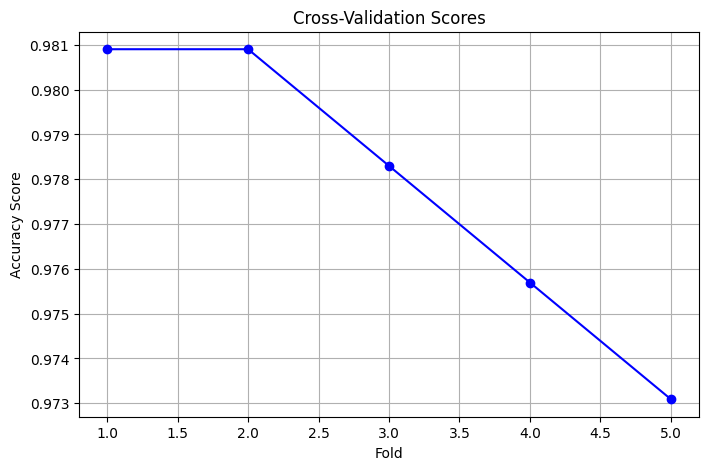

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), scores_poly, marker='o', linestyle='-', color='blue')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Scores')
plt.grid(True)
plt.show()

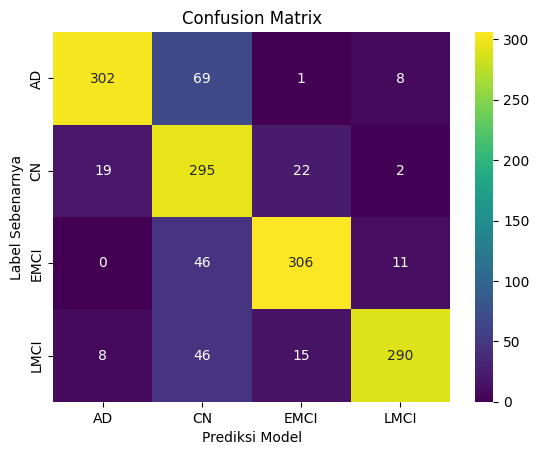

In [34]:
predictions_test = svm_poly.predict(flat_feat_testCNN)

conf_matrix_poly = confusion_matrix(Y_test, predictions_test)

# Membuat heatmap untuk confusion matrix
sns.heatmap(conf_matrix_poly, annot=True, fmt='g', cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.show()

In [35]:
sensitivity = conf_matrix_poly[1, 1] / (conf_matrix_poly[1, 0] + conf_matrix_poly[1, 1])
specificity = conf_matrix_poly[0, 0] / (conf_matrix_poly[0, 0] + conf_matrix_poly[0, 1])

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.9394904458598726
Specificity: 0.8140161725067385


In [36]:
# Data train
predictions_train = svm_poly.predict(flat_feat_trainCNN)
conf_matrix_train = confusion_matrix(Y_train, predictions_train)
sensitivity_train = conf_matrix_train[1, 1] / (conf_matrix_train[1, 0] + conf_matrix_train[1, 1])
specificity_train = conf_matrix_train[0, 0] / (conf_matrix_train[0, 0] + conf_matrix_train[0, 1])

# Menampilkan hasil
print("Sensitivity untuk Data Pelatihan:", sensitivity_train)
print("Specificity untuk Data Pelatihan:", specificity_train)

Sensitivity untuk Data Pelatihan: 0.9862731640356898
Specificity untuk Data Pelatihan: 0.9788583509513742
